# This notebook is to perform EDA on the mouse TOM files generated by my WGCNA codes vs Laura's WGCNA codes

In [1]:
import sys
sys.path.append("../..")
import pandas as pd
import os
from sys import platform 
prefix = 'G:' if platform == 'win32' else '/Volumes/GoogleDrive'
from src.eda.eda_functions import gene_phenotype_corr, plot_dist
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Compare the human critical genes extracted using the published TOM network (generated by Kapoor) vs TOM network generated using my WGCNA codes

In [3]:
# kapoor is using Kapoor's tom. "my" is TOM generated by my codes. "lf" is TOM generated by Laura's codes.
kapoor_critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/epoch=100_alpha=0.1_critical_gene_df.csv')
my_critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/pipeline/human/ml_and_critical_gene_identifier/YC_Apr9_w_old_wgcna/epoch=100_alpha=0.1_critical_gene_df.csv')
lf_critical_gene_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/pipeline/human/ml_and_critical_gene_identifier/YC_Apr12_LF_tom/epoch=100_alpha=0.1_critical_gene_df.csv')

## Plot alcohol traits and old CG vs new CG correlation

In [5]:
expression_meta_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/eda_derived/expression_meta.csv', low_memory = False)

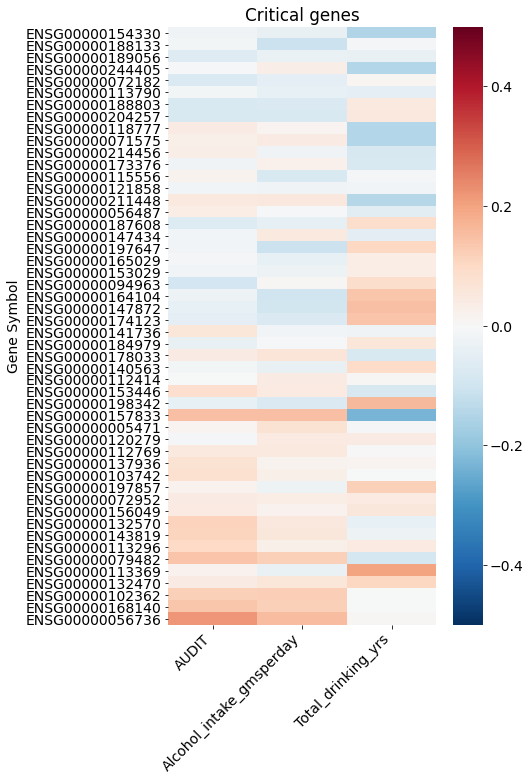

In [6]:
kapoor_cg_corr = gene_phenotype_corr(kapoor_critical_gene_df.gene[:50], expression_meta_df, 'Critical genes')

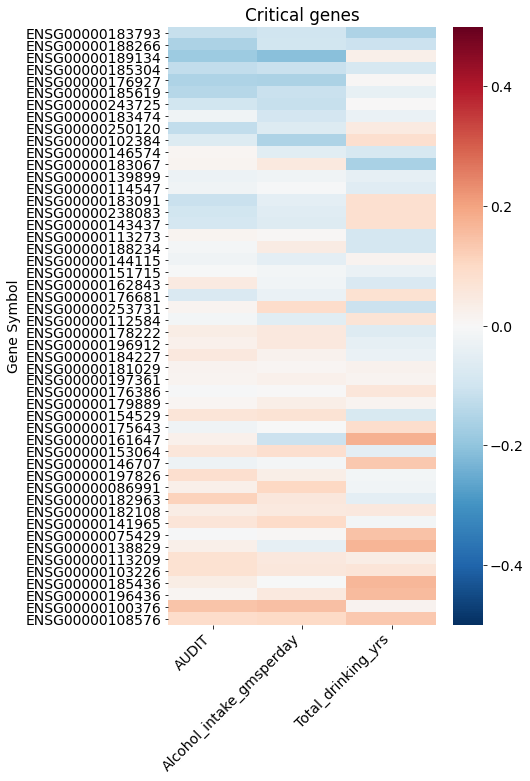

In [7]:
my_cg_corr = gene_phenotype_corr(my_critical_gene_df.gene[:50], expression_meta_df, 'Critical genes')

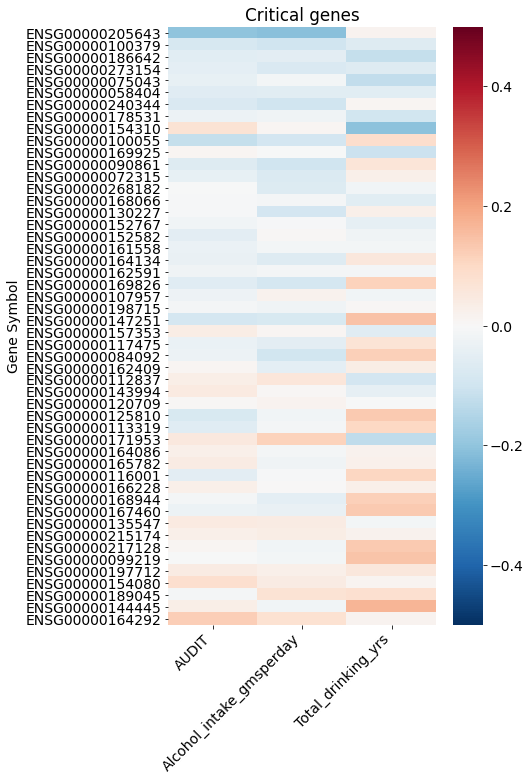

In [8]:
lf_cg_corr = gene_phenotype_corr(lf_critical_gene_df.gene[:50], expression_meta_df, 'Critical genes')

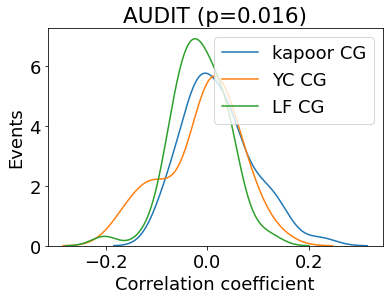

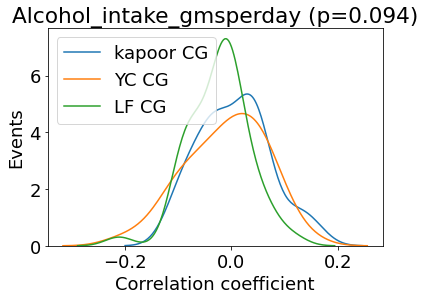

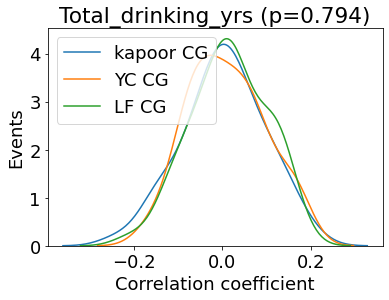

In [11]:
for col in kapoor_cg_corr.columns:
    kapoor_cg_values = kapoor_cg_corr[col]
    my_cg_values = my_cg_corr[col]
    lf_cg_values = lf_cg_corr[col]
    anova_pvalue = f_oneway(kapoor_cg_values, my_cg_values, lf_cg_values)[1]
    plot_dist(kapoor_cg_values, 'kapoor CG', '', 'correlation')
    plot_dist(my_cg_values, 'YC CG', '', 'correlation')
    round_p = round(anova_pvalue, 3) 
    plot_dist(lf_cg_values, 'LF CG', f'{col} (p={round_p})' if round_p > 0 else f'{col} (p < 0.001)', 'correlation')
    plt.show()
    plt.close()

In [15]:
kapoor = pd.DataFrame(kapoor_cg_corr['AUDIT'].values)
kapoor['gene_list'] = 'kapoor'
YC = pd.DataFrame(my_cg_corr['AUDIT'].values)
YC['gene_list'] = 'YC'
LF = pd.DataFrame(lf_cg_corr['AUDIT'].values)
LF['gene_list'] = 'LF'
joined = pd.concat([kapoor, YC, LF]).reset_index(drop = True)
comp = pairwise_tukeyhsd(endog=joined[0], groups=joined['gene_list'], alpha=0.05)
print(comp)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    LF     YC    0.005    0.9 -0.0266 0.0366  False
    LF kapoor    0.036  0.021  0.0044 0.0676   True
    YC kapoor    0.031 0.0555 -0.0006 0.0626  False
---------------------------------------------------


## Overlap between published mouse AUD genes (from Laura) with old and new critical gene lists

In [17]:
def ensembl_to_symbol(ensembl_ids):
    gene_mapping_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/gene_mapping_df.csv')
    gene_mapping_dict = pd.Series(gene_mapping_df['symbol'].values, index = gene_mapping_df['id']).to_dict()
    symbols = list(map(lambda x:gene_mapping_dict[x], ensembl_ids))
    return symbols

In [18]:
kapoor_cg_symbols = ensembl_to_symbol(kapoor_critical_gene_df.gene)
yc_cg_symbols = ensembl_to_symbol(my_critical_gene_df.gene)
lf_cg_symbols = ensembl_to_symbol(lf_critical_gene_df.gene)

In [19]:
gene_mapping_df = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/feature_extraction_derived/gene_mapping_df.csv')
all_gene_symbols = gene_mapping_df.symbol.unique()

In [20]:
mouse_aud_genes = pd.read_csv(prefix + '/Shared drives/NIAAA_ASSIST/Data/IPA analysis/alcohol_genes_141.csv')

In [21]:
mouse_aud_in_human = mouse_aud_genes[mouse_aud_genes['Symbol'].str.upper().isin(list(all_gene_symbols))]

In [22]:
len(mouse_aud_in_human)

90

In [23]:
print('mouse AUD overlap with critical genes')
overlap = set(mouse_aud_in_human['Symbol'].str.upper()).intersection(kapoor_cg_symbols)
print(overlap)
print(len(overlap))

mouse AUD overlap with critical genes
{'FYN', 'TRPV1', 'CHRNA6', 'GRM4', 'CRHR2', 'CHRNA4', 'TLR2'}
7


In [24]:
print('mouse AUD overlap with critical genes')
overlap = set(mouse_aud_in_human['Symbol'].str.upper()).intersection(yc_cg_symbols)
print(overlap)
print(len(overlap))

mouse AUD overlap with critical genes
{'BDKRB2', 'OPRK1', 'ADCY8'}
3


In [25]:
print('mouse AUD overlap with critical genes')
overlap = set(mouse_aud_in_human['Symbol'].str.upper()).intersection(lf_cg_symbols)
print(overlap)
print(len(overlap))

mouse AUD overlap with critical genes
{'GABRD', 'GABRA1', 'APOE', 'CTSF', 'NTSR1', 'GRIN1', 'GRM5', 'CTSS'}
8
